Code source: https://machinelearningknowledge.ai/keras-implementation-of-resnet-50-architecture-from-scratch/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from matplotlib import pyplot

In [ ]:
train_path="/content/drive/MyDrive/Paper_Publications_Files/Paper_3/Model_Training_Dataset/Train/"
val_path="/content/drive/MyDrive/Paper_Publications_Files/Paper_3/Model_Training_Dataset/Val/"
test_path="/content/drive/MyDrive/Paper_Publications_Files/Paper_3/Model_Training_Dataset/Test/"
class_names=os.listdir(train_path)
class_names_val=os.listdir(val_path)
class_names_test=os.listdir(test_path)

In [ ]:
print(class_names)
print(class_names_val)
print(class_names_test)

['Benign', 'Malignant']
['Malignant', 'Benign']
['Benign', 'Malignant']


In [ ]:
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [ ]:
train_generator = train_datagen.flow_from_directory("/content/drive/MyDrive/Paper_Publications_Files/Paper_3/Model_Training_Dataset/Train/",target_size=(224, 224),batch_size=32,shuffle=True,class_mode='binary')
val_generator = val_datagen.flow_from_directory("/content/drive/MyDrive/Paper_Publications_Files/Paper_3/Model_Training_Dataset/Val/",target_size=(224,224),batch_size=32,shuffle=False,class_mode='binary')
test_generator = test_datagen.flow_from_directory("/content/drive/MyDrive/Paper_Publications_Files/Paper_3/Model_Training_Dataset/Test/",target_size=(224,224),batch_size=32,shuffle=False,class_mode='binary')

Found 3644 images belonging to 2 classes.
Found 1561 images belonging to 2 classes.
Found 520 images belonging to 2 classes.


In [ ]:
def identity_block(X, f, filters, stage, block):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet60(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = convolutional_block(X, f=3, filters=[1024, 1024, 4096], stage=6, block='a', s=2)
    X = identity_block(X, 3, [1024, 1024, 4096], stage=6, block='b')
    X = identity_block(X, 3, [1024, 1024, 4096], stage=6, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet60')

    return model

In [ ]:
base_model = ResNet60(input_shape=(224, 224, 3))

In [ ]:
headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 1,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

In [ ]:
model = Model(inputs=base_model.input, outputs=headModel)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

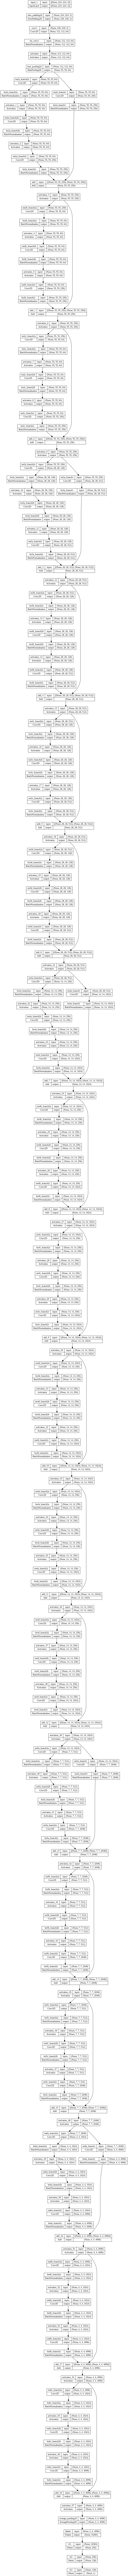

In [ ]:
dot_img_file = '/content/drive/MyDrive/Paper_Publications_Files/Paper_3/ResNet60.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
#Applying Augmentaion on data to avoid overfitting
train_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set =train_datagen.flow_from_directory('/content/drive/MyDrive/Paper_Publications_Files/Paper_3/Model_Training_Dataset/Train',target_size = (224, 224),batch_size = 8,class_mode = 'binary')
val_set = val_datagen.flow_from_directory('/content/drive/MyDrive/Paper_Publications_Files/Paper_3/Model_Training_Dataset/Val',target_size = (224, 224),batch_size = 8,class_mode = 'binary')
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Paper_Publications_Files/Paper_3/Model_Training_Dataset/Test',target_size = (224, 224),batch_size = 8,class_mode = 'binary')
type(training_set)

Found 3644 images belonging to 2 classes.
Found 1561 images belonging to 2 classes.
Found 520 images belonging to 2 classes.


keras.preprocessing.image.DirectoryIterator

In [ ]:
# base_model.load_weights("/content/gdrive/My Drive/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [ ]:
# for layer in base_model.layers:
#     layer.trainable = False

In [ ]:
# for layer in model.layers:
#     print(layer, layer.trainable)

In [ ]:
# es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

In [ ]:
# mc = ModelCheckpoint('/content/gdrive/My Drive/best_model.h5', monitor='val_accuracy', mode='

In [ ]:
#H = model.fit_generator(train_generator,validation_data=test_generator,epochs=100,verbose=1,callbacks=[mc,es])
history = model.fit(training_set,steps_per_epoch = 10,epochs = 200,validation_data = val_set,validation_steps = 5)

Epoch 1/200
10/10 [==============================] - 38s 2s/step - loss: 5.7963 - accuracy: 0.6000 - val_loss: 25.8504 - val_accuracy: 0.2000
Epoch 2/200
10/10 [==============================] - 19s 2s/step - loss: 4.0568 - accuracy: 0.7125 - val_loss: 46.7901 - val_accuracy: 0.1500
Epoch 3/200
10/10 [==============================] - 17s 2s/step - loss: 4.9155 - accuracy: 0.6625 - val_loss: 3.0326 - val_accuracy: 0.8000
Epoch 4/200
10/10 [==============================] - 17s 2s/step - loss: 1.7382 - accuracy: 0.4875 - val_loss: 0.5380 - val_accuracy: 0.7750
Epoch 5/200
10/10 [==============================] - 17s 2s/step - loss: 1.2319 - accuracy: 0.5625 - val_loss: 0.6311 - val_accuracy: 0.7000
Epoch 6/200
10/10 [==============================] - 17s 2s/step - loss: 0.7775 - accuracy: 0.7000 - val_loss: 0.6704 - val_accuracy: 0.6250
Epoch 7/200
10/10 [==============================] - 15s 2s/step - loss: 1.5083 - accuracy: 0.6375 - val_loss: 0.8440 - val_accuracy: 0.2250
Epoch 8/200

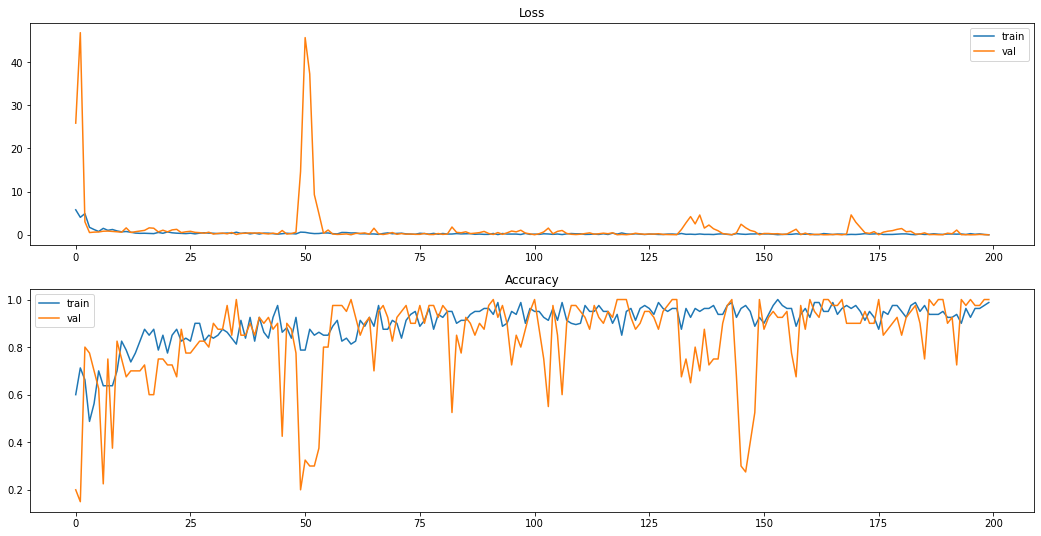

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18,9)

# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='val')
pyplot.legend()
pyplot.savefig('/content/drive/MyDrive/Paper_Publications_Files/Paper_3/TrainTest_LossAccuracy_Graph_ResNet60.png')
pyplot.show()

In [ ]:
test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)

predictions = model.predict_generator(test_set, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())

In [ ]:
import sklearn.metrics as metrics
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      Benign       0.72      1.00      0.84       376
   Malignant       0.00      0.00      0.00       144

    accuracy                           0.72       520
   macro avg       0.36      0.50      0.42       520
weighted avg       0.52      0.72      0.61       520



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
confusion_matrix = metrics.confusion_matrix(y_true=true_classes, y_pred=predicted_classes)

In [ ]:
confusion_matrix

array([[376,   0],
       [144,   0]])

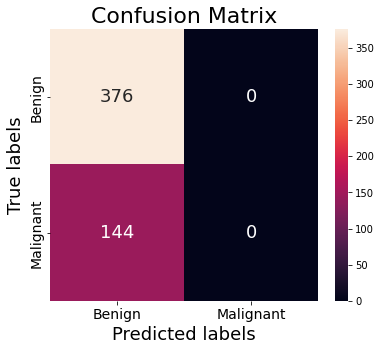

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6,5)
ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax, annot_kws={"fontsize":18});  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=18);
ax.set_ylabel('True labels', fontsize=18);
ax.set_title('Confusion Matrix',fontsize=22);
ax.xaxis.set_ticklabels(['Benign', 'Malignant'],fontsize=14);
ax.yaxis.set_ticklabels(['Benign', 'Malignant'],fontsize=14);

plt.savefig('/content/drive/MyDrive/Paper_Publications_Files/Paper_3/Confusion_Matrix_ResNet60.png')

In [ ]:
#model.load_weights("/content/gdrive/My Drive/best_model.h5")

In [ ]:
# model.evaluate_generator(test_generator)

In [ ]:
# model_json = model.to_json()
# with open("/content/gdrive/My Drive/model.json","w") as json_file:
#   json_file.write(model_json)

In [ ]:
# from keras.models import model_from_json

In [ ]:
# def predict_(image_path):
#     #Load the Model from Json File
#     json_file = open('/content/gdrive/My Drive/model.json', 'r')
#     model_json_c = json_file.read()
#     json_file.close()
#     model_c = model_from_json(model_json_c)
#     #Load the weights
#     model_c.load_weights("/content/gdrive/My Drive/best_model.h5")
#     #Compile the model
#     opt = SGD(lr=1e-4, momentum=0.9)
#     model_c.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
#     #load the image you want to classify
#     image = cv2.imread(image_path)
#     image = cv2.resize(image, (224,224))
#     cv2_imshow(image)
#     #predict the image
#     preds = model_c.predict(np.expand_dims(image, axis=0))[0]
#     if preds==0:
#         print("Predicted Label:Cat")
#     else:
#         print("Predicted Label: Dog")

In [ ]:
# predict_("/content/gdrive/My Drive/datasets/test/aDog/4.jpg")

In [ ]:
# predict_("/content/gdrive/My Drive/datasets/test/Cat/10.jpg")

In [ ]:
# predict_("/content/gdrive/My Drive/datasets/test/Cat/7.jpg")